# XGBoost Model
- Attempting to predict likelyhood of income either <=50K or >50K from 1994 Census database
- https://jessesw.com/XG-Boost/

# Setting up environment

In [1]:
%attachments

Training Cluster    ML Engine
------------------  -----------
pythonmldl          python


In [2]:
%%pythonmldl
print('test')

History URL: http://bluedata-56.bdlocal:10001/history/7


In [3]:
%logs --url http://bluedata-56.bdlocal:10001/history/1

Job Status: Finished
test





In [4]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
sns.set(font_scale=1.5)

%matplotlib inline 

In [5]:
def saveInProjectRepo(path):
   ProjectRepo = os.popen('bdvcli --get cluster.project_repo').read().rstrip()
   return str(ProjectRepo + '/' + path)

# Data preprocessing

In [6]:
train_file = saveInProjectRepo('data/UCI_Income/adult_data.csv')
test_file = saveInProjectRepo('data/UCI_Income/adult_test.csv')

In [7]:
train_set = pd.read_csv(train_file, header=None)
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
test_set = pd.read_csv(test_file, skiprows=1, header=None)
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


## Initial Findings
1. No column headers (can fix using dataset description from website)
2. Some "?" in test data 
3. Target values differ in train and test set

#### 1. Fix column headers

In [9]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [10]:
train_set.columns = col_labels
test_set.columns = col_labels

#### 2. Clean up ? in data

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [13]:
train_set.replace(' ?', np.nan).dropna().shape

(30162, 15)

In [14]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [15]:
# removing rows with "?" from our dataframes 
train_no_missing = train_set.replace(' ?', np.nan).dropna()
test_no_missing = test_set.replace(' ?', np.nan).dropna()

#### 3. Fix targets (remove the extra periods from '<=50K.' to '<=50K')

In [16]:
test_no_missing['wage_class'] = test_no_missing.wage_class.replace({' <=50K.' : ' <=50K', ' >50K.' : ' >50K'})

In [17]:
test_no_missing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [18]:
train_no_missing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

## Applying ordinal encoding to categoricals
- ordinal encoding: convert string labels to integer values 1 through k. First unique value in column becomes 1, the second becomes 2, the third becomes 3, adn so on


In [19]:
#combine the datasets together first
combined_set = pd.concat([train_no_missing, test_no_missing], axis=0)
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [20]:
#Visualizations after initial cleaning of dataset 
group = combined_set.groupby('wage_class')
group

In [21]:
#encode non-numerical features into numeric values using pandas Cateogrical codes 
#and generating categorical codes mapping into dictionary
cat_codes = {}
for feature in combined_set.columns: 
    if combined_set[feature].dtype == 'object':
        #workclass : { occupation : number }
        temp_dict = {}
        feature_codes = list(pd.Categorical(combined_set[feature]).codes)
        feature_list = list(combined_set[feature])
        for i in range(len(feature_codes)):
            temp_dict[feature_list[i].strip()] = int(feature_codes[i])
            if len(temp_dict) > len(feature_list):
                break
        cat_codes[feature] = temp_dict
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [22]:
# saving encoding to json file to be used for scoring script
json_file = saveInProjectRepo('data/UCI_Income/encoding.json')
with open(json_file, 'w') as file:
    json.dump(cat_codes, file)

In [23]:
#split combined set back into test/train split 
final_train = combined_set[:train_no_missing.shape[0]] 
final_test = combined_set[train_no_missing.shape[0]:]
final_train.to_csv(saveInProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
final_test.to_csv(saveInProjectRepo('data/UCI_Income/adult_test_cleaned.csv'))

In [24]:
#extracting target values from our test and train sets 
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

# Model Development

In [25]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

### First model

In [26]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_Rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample' : 0.8, 'colsample_bytree': 0.8, 
              'objective': 'binary:logistic'}

#optimizing for accuracy, GBM = gradient boost model
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [27]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_Rate=0.1, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=1000, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
             pre_dispatch='2*n

In [28]:
optimized_GBM.cv_results_

{'mean_fit_time': array([12.81176977, 12.39020672, 12.8919106 , 19.37091618, 19.71099648,
        19.27676668, 26.55580301, 26.14100518, 25.19000549]),
 'std_fit_time': array([0.29424796, 0.07806213, 0.58880479, 0.79518183, 0.5497601 ,
        0.54128105, 0.41005756, 0.30951794, 0.69587047]),
 'mean_score_time': array([0.22650123, 0.2238194 , 0.26862321, 0.43970375, 0.43426838,
        0.43569727, 0.70602131, 0.65020351, 0.60279717]),
 'std_score_time': array([0.01232047, 0.00480001, 0.08202193, 0.01304838, 0.00912731,
        0.01788755, 0.01199705, 0.0323401 , 0.02755831]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_val

### Second model
Tuning other hyperparameters in an attempt to achieve higher mean accuracy

In [29]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]}
ind_params = {'n_estimators': 1000, 'seed': 0, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 
              'max_depth': 3, 'min_child_weight': 1}
                    
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', cv=5, n_jobs=-1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01],
                         'subsample': [0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_t

In [30]:
optimized_GBM.cv_results_

{'mean_fit_time': array([14.30123992, 13.66151872, 12.5833858 , 13.93203964, 13.47633758,
        12.43713722]),
 'std_fit_time': array([0.63273447, 0.47055932, 0.51710817, 0.78547131, 0.29734094,
        0.16504855]),
 'mean_score_time': array([0.23429117, 0.21799669, 0.21792712, 0.20365939, 0.20211711,
        0.2012732 ]),
 'std_score_time': array([0.02506125, 0.00436202, 0.00426266, 0.00370023, 0.00149779,
        0.00324414]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rate': 0.1, 'subsample': 0.8},
  {'learning_rate': 0.1, 'subsample': 0.9},
  {'learning_rate': 0.01, 'subsample': 0.7},


### Third model
Utilize XGBoost's built-in cv which allows early stopping to prevent overfitting

In [31]:
xgdmat = xgb.DMatrix(final_train, y_train)

/opt/miniconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/miniconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [32]:
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}

cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)

In [33]:
print('Best iteration:', len(cv_xgb))

Best iteration: 326


In [34]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
321,0.118543,0.001480,0.131623,0.001742
322,0.118610,0.001445,0.131324,0.001883
323,0.118526,0.001422,0.131291,0.001763
324,0.118643,0.001401,0.131391,0.001688
325,0.118693,0.001343,0.131158,0.001922


### Final Model

In [35]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 326)

# Plot feature importances

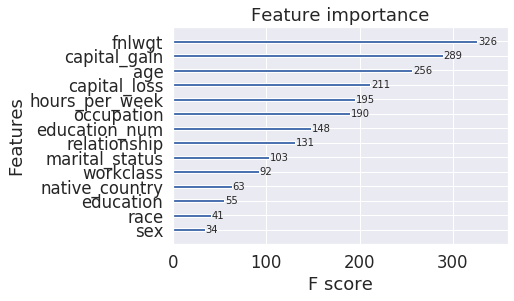

In [36]:
xgb.plot_importance(final_gb)

In [37]:
importances = final_gb.get_fscore()
importances

{'relationship': 131,
 'education_num': 148,
 'capital_gain': 289,
 'age': 256,
 'hours_per_week': 195,
 'education': 55,
 'fnlwgt': 326,
 'capital_loss': 211,
 'marital_status': 103,
 'sex': 34,
 'occupation': 190,
 'workclass': 92,
 'native_country': 63,
 'race': 41}

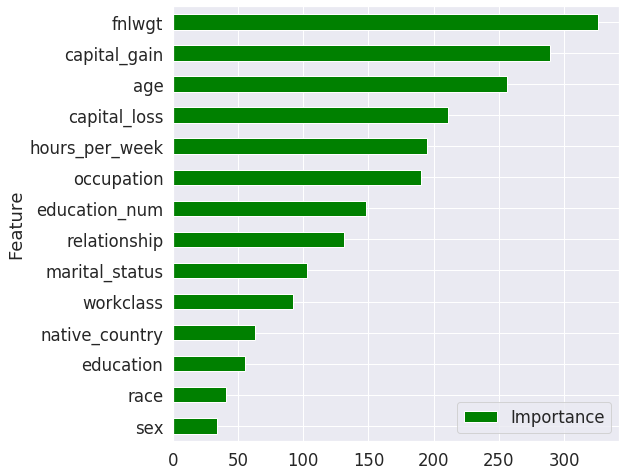

In [38]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace=True)
importance_frame.plot(kind='barh', x='Feature', figsize=(8,8), color='green')

# Increase dataset size by duplicating data 

In [39]:
# final_train = combined_set[:train_no_missing.shape[0]] 
# final_test = combined_set[train_no_missing.shape[0]:]

# final_train_100 = pd.concat([final_train] * 100, ignore_index=True)
# final_train_100.info()

In [40]:
# final_test_100 = pd.concat([final_test] * 100, ignore_index=True)
# final_test_100.info()

#### Saving replicated data into project repo

In [41]:
# final_train_100.to_csv(saveInProjectRepo('data/UCI_Income/adult_data_100.csv'))
# final_test_100.to_csv(saveInProjectRepo('data/UCI_Income/adult_test_100.csv'))

# Build model remotely on a distributed Python deep learning cluster on larger dataset 

In [79]:
%%pythonmldl

# Importing libraries 
print("Importing libraries")
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV

# Start time 
print("Start time: ", datetime.datetime.now())

# Project repo path function
def saveInProjectRepo(path):
   ProjectRepo = os.popen('bdvcli --get cluster.project_repo').read().rstrip()
   return str(ProjectRepo + '/' + path)

# Reading in data 
print("Reading in data")
train = pd.read_csv(saveInProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
print("Done reading in data")

# Extracting target values 
y_train = train.pop('wage_class')

# Model development / Training
print("Training...")
xgdmat = xgb.DMatrix(train, y_train)
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}
cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)
optimal_rounds = len(cv_xgb)
final_gb = xgb.train(our_params, xgdmat, num_boost_round = optimal_rounds)

# Save model into project repo
print("Saving model")
final_gb.save_model(saveInProjectRepo('models/XGB_Income/XGB.model'))

# Finish time
print("End time: ", datetime.datetime.now())

History URL: http://bluedata-57.bdlocal:10001/history/9


In [83]:
%logs --url http://bluedata-57.bdlocal:10001/history/9

Job Status: Finished
Importing libraries
Start time:  2019-08-12 15:31:17.066344
Reading in data
Done reading in data
Training...
Saving model
End time:  2019-08-12 15:31:48.088678





# Testing scoring with generated model 

In [122]:
cleaned = pd.read_csv(saveInProjectRepo('data/UCI_Income/adult_test_cleaned.csv'))
cleaned.tail(1)

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
15059,16280,35,3,182148,9,13,2,3,0,4,1,0,0,60,38,1


In [77]:
#Running with final_gb model from local notebook 
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = final_gb.predict(mat)
y_pred

array([0.8078612], dtype=float32)

In [119]:
#Running with loaded model 
temp_gb = xgb.Booster({'nthread':325})
temp_gb.load_model(saveInProjectRepo('models/XGB_Income/XGB.model'))
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = temp_gb.predict(mat)
y_pred

array([0.00455112], dtype=float32)

## Observations
- save_model function doesn't save the optimized model, only saves the last iteration
- need to rebuild model and save as pickle file 

# Same model construction, but saving model as pickle instead
- Using xgb.save_model doesn't save the best iteration of the training 
- Trying to save as pickle file instead 

In [129]:
%%pythonmldl

# Importing libraries 
print("Importing libraries")
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV

# Start time 
print("Start time: ", datetime.datetime.now())

# Project repo path function
def saveInProjectRepo(path):
   ProjectRepo = os.popen('bdvcli --get cluster.project_repo').read().rstrip()
   return str(ProjectRepo + '/' + path)

# Reading in data 
print("Reading in data")
train = pd.read_csv(saveInProjectRepo('data/UCI_Income/adult_train_cleaned.csv'))
print("Done reading in data")

# Extracting target values 
y_train = train.pop('wage_class')
train.pop('Unnamed: 0')

# Model development / Training
print("Training...")
xgdmat = xgb.DMatrix(train, y_train)
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic',
              'max_depth': 3, 'min_child_weight': 1}
cv_xgb = xgb.cv(params=our_params, dtrain=xgdmat, num_boost_round=3000, metrics=['error'],
                early_stopping_rounds=100)
optimal_rounds = len(cv_xgb)
final_gb = xgb.train(our_params, xgdmat, num_boost_round = optimal_rounds)

# Save model into project repo
print("Saving model")
pickle.dump(final_gb, open( saveInProjectRepo('models/XGB_Income/') + "XGB.pickle.dat", "wb"))

# Finish time
print("End time: ", datetime.datetime.now())


History URL: http://bluedata-57.bdlocal:10001/history/12


In [134]:
%logs --url http://bluedata-57.bdlocal:10001/history/12

Job Status: Finished
Importing libraries
Start time:  2019-08-13 08:40:46.658199
Reading in data
Done reading in data
Training...
Saving model
End time:  2019-08-13 08:41:13.961270





# Testing with loading pickle model 

In [136]:
import pickle 
model = pickle.load(open(saveInProjectRepo('models/XGB_Income/') + "XGB.pickle.dat", "rb"))
temp = cleaned.tail(1)
y_test = temp.pop('wage_class')
temp.set_index('age')
temp.pop('Unnamed: 0')
mat = xgb.DMatrix(temp) 
y_pred = model.predict(mat)
y_pred

array([0.8078612], dtype=float32)

Using scoring with pickle model yields proper results